In [1]:
import torch
from PIL import Image
from torch import nn
import numpy as np
from tqdm import tqdm
import random
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from surface_dice import SurfaceDiceMetric
import wandb
import albumentations as A
from math import ceil
device = "cuda" if torch.cuda.is_available() else "cpu"
input_dir = "/kaggle/input/blood-vessel-segmentation/"
train_dir = input_dir + "train/"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
imgs_dir = f"{train_dir}kidney_1_dense/images/"
msks_dir = f"{train_dir}kidney_1_dense/labels/"
slices_ids = sorted(os.listdir(imgs_dir))
patch_size = 224



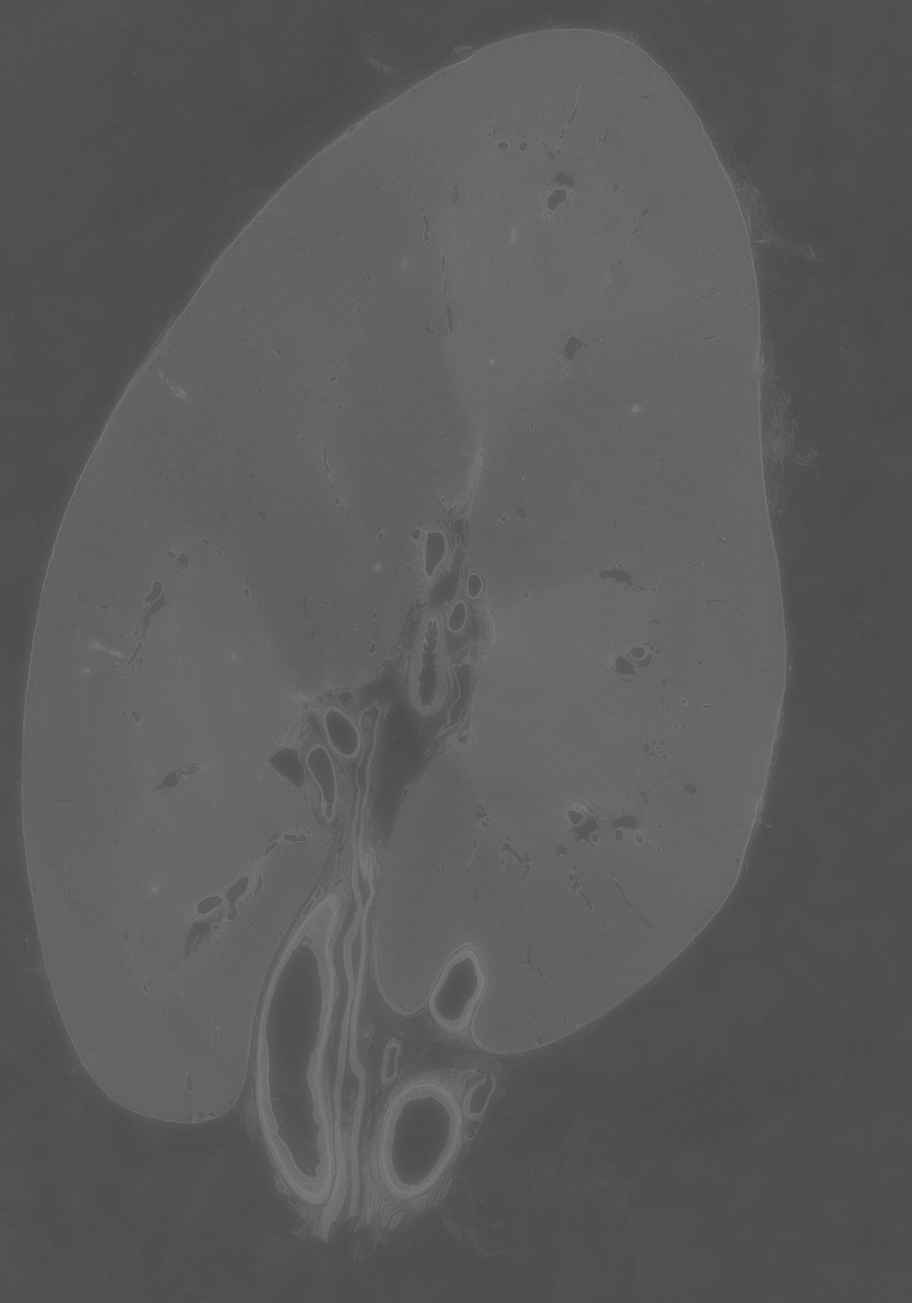

In [3]:
img = Image.open(imgs_dir + slices_ids[888])
img

In [4]:
x1 = np.array(img, dtype=np.float32)
x1 = torch.from_numpy(x1)[None, None]
h, w = x1.shape[-2:]
x1.shape

torch.Size([1, 1, 1303, 912])

In [5]:
class Patcher:
    def __init__(self, h, w, p_size, overlap):
        self.h, self.w = h, w
        self.p_size = p_size
        self.overlap = overlap

        self.stride = p_size - overlap
        self.h_pad = self.stride * ceil((h - p_size) / self.stride) + p_size - h
        self.w_pad = self.stride * ceil((w - p_size) / self.stride) + p_size - w

        self.unfold = torch.nn.Unfold(kernel_size=(p_size, p_size), stride=self.stride)
        self.fold = torch.nn.Fold(
            output_size=(h + self.h_pad, w + self.w_pad),
            kernel_size=(p_size, p_size),
            stride=self.stride
        )

    def extract_patches(self, x):
        assert x.ndim == 4
        x = F.pad(x, (0, self.w_pad, 0, self.h_pad), mode="reflect")
        B, C, H, W = x.shape

        patches = x.unfold(2, self.p_size, self.stride).unfold(3, self.p_size, self.stride)  # (B, C, h_steps, w_steps, p_size, p_size)
        patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()                             # (B, h_steps, w_steps, C, p_size, p_size)
        patches = patches.view(B, -1, C, self.p_size, self.p_size)                           # (B, n_patches, p_size, p_size)
        return patches
    
    def merge_patches(self, patches):
        assert patches.ndim == 5
        B, N, C, _, _ = patches.shape

        # fold expects the patches tensor to have a shape (B, C * p_size * p_size, N)
        x = patches.permute(0, 2, 3, 4, 1).view(B, C * self.p_size * self.p_size, N)  
        x = self.fold(x)  # (B, C, h + pad_h, w + pad_w)

        # as patches overlap we average the values of overlapping pixels
        weight_mask = 1 / self.fold(self.unfold(torch.ones(x.shape[-3:], device=patches.device)))
        x = x * weight_mask

        x = x[:, :, :self.h, :self.w]
        return x

overlap = 50
patcher = Patcher(h, w, p_size=patch_size, overlap=overlap)

In [6]:
# patcher = Patcher(5, 5, patch_size=3, overlap=1)
# x = torch.arange(50.).view(1, 2, 5, 5)
# print(x)
# patches = patcher.extract_patches(x)

In [7]:
patches = patcher.extract_patches(x1)

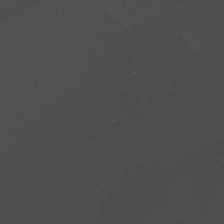

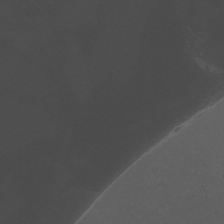

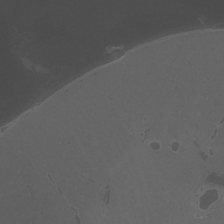

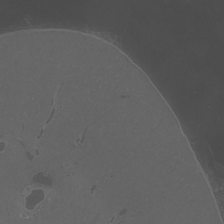

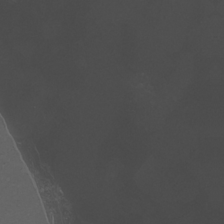

In [8]:
for i in range(5):
    display(Image.fromarray(patches[0, i, 0].numpy().astype(np.uint16)))

torch.Size([1, 1, 1303, 912])


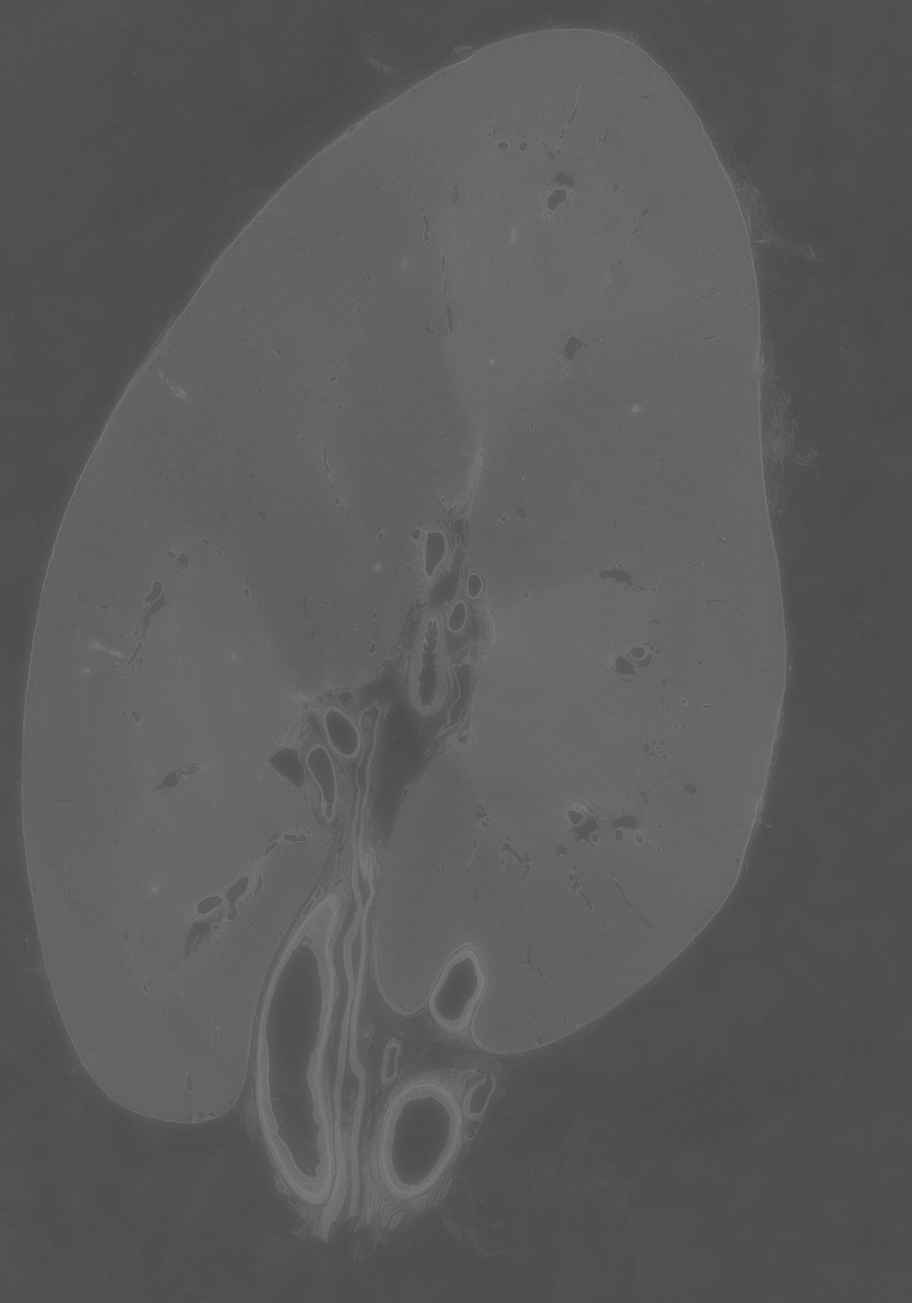

In [9]:
x2 = patcher.merge_patches(patches)
print(x2.shape)

Image.fromarray(x2.squeeze().numpy().astype(np.uint16))

In [13]:
x1.flatten(end_dim=1)

tensor([[[20873., 20931., 21169.,  ..., 20464., 20141., 20361.],
         [20729., 20869., 20997.,  ..., 20170., 20361., 20064.],
         [20845., 21065., 20762.,  ..., 20212., 20104., 20433.],
         ...,
         [21568., 21281., 21304.,  ..., 20675., 20673., 20327.],
         [21348., 20966., 20850.,  ..., 20335., 20593., 20367.],
         [21399., 21011., 20670.,  ..., 20438., 20647., 20704.]]])

In [10]:
torch.equal(x1, x2)

True